# Overview of Neural Networks

In [1]:
## Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import sklearn.linear_model
import matplotlib

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

/Library/Python/2.7/site-packages/matplotlib-override/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


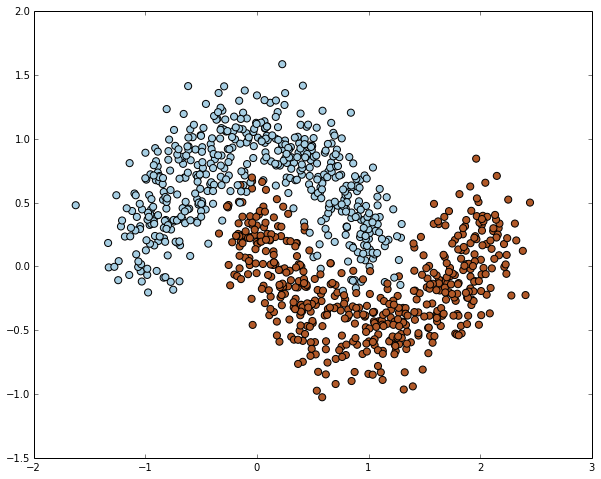

In [2]:
## Generate non-separable data.
data, labels = sklearn.datasets.make_moons(1000, noise=0.20)
plt.scatter(data[:,0], data[:,1], s=50, c=labels, cmap=plt.cm.Paired)

### Logistic Classification Method

In [3]:
## We start by implementing a logistic (linear) classifier.
logistic = sklearn.linear_model.LogisticRegressionCV()
logistic.fit(data,labels)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring=None, solver='lbfgs', tol=0.0001, verbose=0)

In [4]:
def plot_decision_boundary(pred_func):
    ## Copy data.
    X = data.copy()
    y = labels.copy()
    
    # Set min and max values and give it some padding.
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.03
    # Generate a grid of points with distance h between them.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid.
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples.
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)
    plt.scatter(X[:, 0], X[:, 1], s = 50, c=y, cmap=plt.cm.Paired)

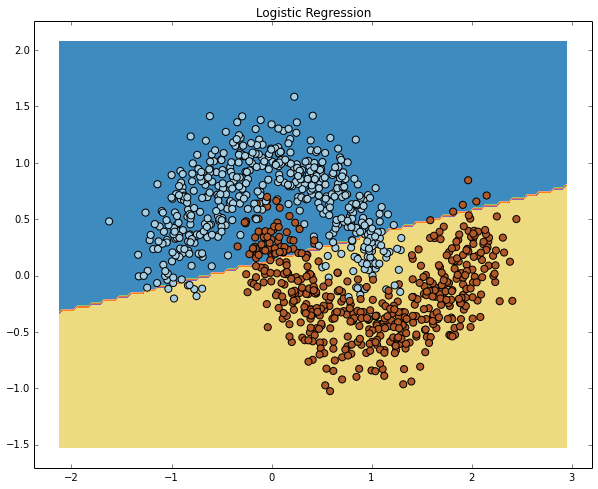

In [5]:
plot_decision_boundary(lambda x: logistic.predict(x))
plt.title("Logistic Regression")

### Moving from logistic to neural networks.

Logistic regression correctly classifies a good number of observations, but doesn't pick up the moon shape from the data. Now we will try a neural network, on which we have:

**1)** One input layer for each dimension (2 in total).  
**2)** One input layer for each classification (2 in total).  
**3)** An arbitrary larger number of hidden layers.  
**4)** A *tanh* activation function for the input layer, and a *softmax* for the output one.

*Input of layer 1*: $ \quad z_1 = xW_1 + b_1 \qquad$ *Output of layer 1*: $ \quad a_1 = tanh(z_1)$

*Input of layer 2*: $ \quad z_2 = a_1W_2 + b_2 \qquad$ *Output of layer 1*: $ \quad a_2 = softmax(z_2) = \hat{y}$

The parameters our model needs to learn are then $(W_1, W_2, b_1, b_2)$. For this we will use *cross-entropy loss function*, defined as:

$L(y,\hat{y}) = \sum_N \sum_C y_{n,1} log(\hat{y})_{n,i}$

Where $N$ are the total of observations and $C$ the different classes.

### Neural Network Implementation

In [6]:
num_examples = len(data)
nn_input_dim = 2
nn_output_dim = 2

In [7]:
## We start by defining the loss function.
def calculate_loss(model, x, y):
    num_batch = len(x)
    
    ## Copy data.
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    ## Forward propagation that goes through the input layers:
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    ## Probability:
    probs = exp_scores / np.sum(exp_scores, axis = 1, keepdims=True)
    ## Select logprobs for observations where y=1.
    correct_logprobs = -np.log(probs[range(num_batch), y])
    data_loss = np.sum(correct_logprobs)
    ## Add regularization term (optional).
    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))
    return 1./num_examples * data_loss

In [8]:
## We define a predict function that works the same way as defined above.
def predict(model, x): 
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    z1 = x.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis = 1, keepdims=True)
    return np.argmax(probs, axis=1)

In [9]:
## Now we build the back-propagation neural network model.
def build_model(nn_hdim, epochs=20000, batch=False, print_loss=False):
    ## Initialize parameters to random.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))
    
    model = {}
    X = data.copy()
    y = labels.copy()
    num_batch = len(X)
    
    ## Gradient descent.
    
    for i in xrange(0, epochs):
        
        ## Get random sample in the case of BGD.
        if batch:
            index = np.random.choice(num_examples, 256)
            X = data[index].copy()
            y = labels[index].copy()
            num_batch = len(index)
        
        ## Forward propagation.
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis = 1, keepdims = True)
        
        ## Backward propagation.
        delta3 = probs
        delta3[range(num_batch), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis = 0, keepdims = True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = (X.T).dot(delta2)
        db1 = np.sum(delta2, axis = 0)
        
        ## Add regularization.
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1
        
        ## Update parameters.
        W1 += -epsilon * dW1 
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}
        
        ## Print loss on current stage.
        if print_loss and i % 1000 == 0:
            print "Training loss at epoch %i is %f." %(i, calculate_loss(model, X, y)) 
        
    return model

Training loss at epoch 0 is 0.109769.
Training loss at epoch 1000 is 0.007102.
Training loss at epoch 2000 is 0.007180.
Training loss at epoch 3000 is 0.015512.
Training loss at epoch 4000 is 0.009348.
Training loss at epoch 5000 is 0.008627.
Training loss at epoch 6000 is 0.012200.
Training loss at epoch 7000 is 0.012675.
Training loss at epoch 8000 is 0.014325.
Training loss at epoch 9000 is 0.008547.
Training loss at epoch 10000 is 0.008076.
Training loss at epoch 11000 is 0.008796.
Training loss at epoch 12000 is 0.009667.
Training loss at epoch 13000 is 0.014115.
Training loss at epoch 14000 is 0.010640.
Training loss at epoch 15000 is 0.016423.
Training loss at epoch 16000 is 0.023216.
Training loss at epoch 17000 is 0.015505.
Training loss at epoch 18000 is 0.010165.
Training loss at epoch 19000 is 0.013835.


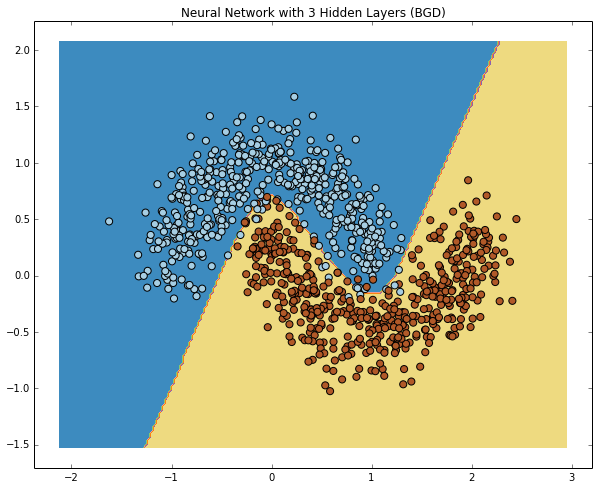

In [10]:
## Estimate model.
epsilon = 0.01
reg_lambda = 0.01 
model = build_model(3, batch = True, print_loss = True)
plot_decision_boundary(lambda x: predict(model, x))
plt.title("Neural Network with 3 Hidden Layers (BGD)")

### Implementation with different number of layers.

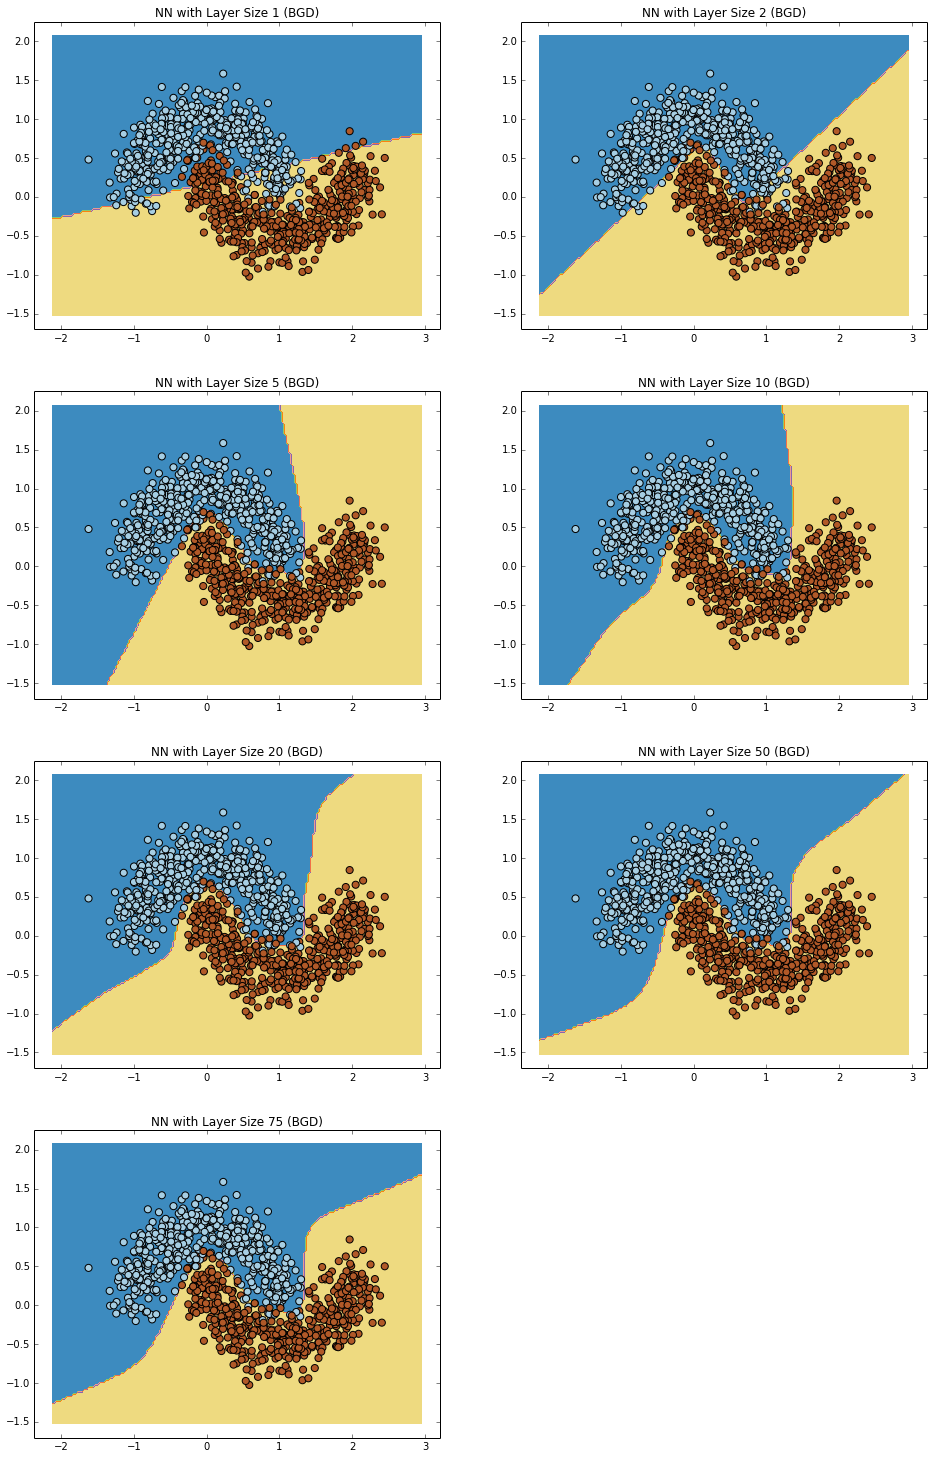

In [11]:
plt.figure(figsize=(16,32))
hidden_layer_dims = [1, 2, 5, 10, 20, 50, 75]

for i, nn_hdim in enumerate(hidden_layer_dims):
    plt.subplot(5,2,i+1)
    plt.title("NN with Layer Size %d (BGD)" % nn_hdim)
    model = build_model(nn_hdim, batch = True)
    plot_decision_boundary(lambda x: predict(model, x))

plt.show()